In [23]:
import numpy as np
import numpy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys,os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import clock

from data_providers import MultiTSDataProvider
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
base_dir = '../data/'
full_df = pd.read_csv(base_dir+'train_1.csv').fillna(0)
X = np.log(full_df.drop('Page', axis=1).values + 1)
scaler = StandardScaler()
# discussion on which scaler to use here: https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38274
# each ts should have 0 mean and unit variance
# since the time series are the 'features' being scaled, transpose first
X = scaler.fit_transform(X.T).T

In [28]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq import tied_rnn_seq2seq
hidden_dim = 200
output_dim = 1
input_dim = 1
layers_stacked_count = 2
n_cond = 30
n_pred = 30
learning_rate = 0.007
lr_decay = 0.92 
momentum = 0.5

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    train = tf.placeholder(tf.bool)
    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(n_cond-1)
    ]
    
    enc_inp.insert(0, tf.zeros_like(enc_inp[0], dtype=np.float32))

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(n_pred)
    ]

    go_sym = tf.placeholder(tf.float32, shape=(None, output_dim), name="GO")

    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + [tf.zeros_like(v) for v in enc_inp[:-1]]
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO")] + enc_inp[1:]
    dec_inp = [go_sym] + expected_sparse_output[:-1] # feed previous target as next input

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    def looper(output, i):
        return output_scale_factor * (tf.matmul(output, w_out) + b_out)

    dec_outputs, dec_memory = tf.cond(train, lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell),
                                      lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell, loop_function=looper))
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [29]:
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
#         output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        output_loss += tf.reduce_mean(tf.abs(_y - _Y)) # average loss across batch for single timestep
    loss = output_loss # loss averaged across batch but summed across timesteps
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [ ]:
def feed_vals(inps, targs, feed_dict, n_cond, n_pred):
    for i in range(n_cond-1):
        feed_dict[enc_inp[i+1].name] = input_batch[:,i].reshape(-1,1)
    feed_dict[go_sym] = input_batch[:, n_cond-1].reshape(-1,1)
    for i in range(n_pred):
        feed_dict[expected_sparse_output[i].name] = target_batch[:,i].reshape(-1,1)
    return feed_dict

In [27]:
X.shape

(145063, 550)

In [ ]:
import time
import os
ts = int(time.time())
model_dir = 'checkpoints/{}-{}-{}'.format(ts, n_cond, n_pred)
os.mkdir(model_dir)

n_ts = None
stride_length = 200
train_data = MultiTSDataProvider(X,
                                 n_ts=n_ts, 
                                 n_cond=n_cond, 
                                 n_pred=n_pred, 
                                 stride_length=-1)
val_data = MultiTSDataProvider(X,
                               n_ts=n_ts,
                               n_cond=n_cond,
                               n_pred=n_pred,
                               which_set='val')

stride_length = n_cond + n_pred

sess = tf.Session()
sess.run(tf.global_variables_initializer())
epochs = 500
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    with clock():
        for input_batch, target_batch in train_data:
        #     print(input_batch.shape, target_batch.shape)
            feed_dict = {train: True}
            # each decoder input is batch size x 1
            feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
            _, err = sess.run([train_op, loss], feed_dict=feed_dict)
            mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
            mean_errs = np.abs(mean_preds - target_batch)
            batch_mean_err = np.sum(np.mean(mean_errs, axis=0))
            running_error += err
            mean_running_error += batch_mean_err
        running_error /= train_data.num_batches
        mean_running_error /= train_data.num_batches
        saver.save(sess, model_dir+'/model.ckpt'.format(ts), global_step=e+1)
    for input_batch, target_batch in val_data:
        feed_dict = {train: False}
        feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
        val_err = sess.run(loss, feed_dict=feed_dict)
        # this time we don't need to feed in either decoder_inputs or targets
        val_error += val_err
    val_error /= val_data.num_batches
    print("""End of epoch {0}: running error average = {1:.3f}
             mean error average = {2:.3f}
             val error average = {3:.3f}""".format(e + 1, running_error, mean_running_error, val_error))

(145063, 490)
(145063, 30) (145063, 30)
(145063, 60)
(145063, 30) (145063, 30)


In [18]:
import time
import os
from datasets import generate_x_y_data_v3
ts = int(time.time())
model_dir = 'checkpoints/fourier/{}-{}-{}'.format(ts, n_cond, n_pred)
os.mkdir(model_dir)

n_ts = None
stride_length = 200
stride_length = n_cond + n_pred

sess = tf.Session()
sess.run(tf.global_variables_initializer())
epochs = 100
batch_size = 50
report_error_avg = 1000
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    with clock():
        for i in range(int(report_error_avg/batch_size)):
            input_batch, target_batch = generate_x_y_data_v3(True, batch_size)
            input_batch = input_batch.reshape(input_batch.shape[0],-1).T
            target_batch = target_batch.reshape(target_batch.shape[0],-1).T
            #     print(input_batch.shape, target_batch.shape)
            feed_dict = {train: True}
            # each decoder input is batch size x 1
            feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
            _, err = sess.run([train_op, loss], feed_dict=feed_dict)
            mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
            mean_errs = np.abs(mean_preds - target_batch)
            batch_mean_err = np.sum(np.mean(mean_errs, axis=0))
            running_error += err
            mean_running_error += batch_mean_err
        running_error /= int(report_error_avg/batch_size)
        mean_running_error /= int(report_error_avg/batch_size)
        saver.save(sess, model_dir+'/model.ckpt'.format(ts), global_step=e+1)
    print("""End of epoch {0}: running error average = {1:.3f}
             mean error average = {2:.3f}""".format(e + 1, running_error, mean_running_error))

# ex 2 results: batchsize 50, learning_rate = 0.007, lr_decay = 0.92, momentum = 0.5, 2000 batches, mae loss
# ~ 25 s per 'epoch' of 20 batches, .697 loss after 100 epochs, 0.910 after 50


Elapsed time 27.212625980377197 seconds
End of epoch 1: running error average = 10.638
             mean error average = 9.594
Elapsed time 23.96803092956543 seconds
End of epoch 2: running error average = 9.192
             mean error average = 9.598
Elapsed time 21.976139068603516 seconds
End of epoch 3: running error average = 8.951
             mean error average = 9.555
Elapsed time 23.73822808265686 seconds
End of epoch 4: running error average = 8.052
             mean error average = 9.482
Elapsed time 27.454231023788452 seconds
End of epoch 5: running error average = 5.166
             mean error average = 9.599
Elapsed time 25.51190710067749 seconds
End of epoch 6: running error average = 3.809
             mean error average = 9.469
Elapsed time 25.53242015838623 seconds
End of epoch 7: running error average = 3.392
             mean error average = 9.522
Elapsed time 28.676618099212646 seconds
End of epoch 8: running error average = 3.201
             mean error average = 9

Elapsed time 25.69583821296692 seconds
End of epoch 66: running error average = 0.843
             mean error average = 9.492
Elapsed time 26.89317798614502 seconds
End of epoch 67: running error average = 0.822
             mean error average = 9.534
Elapsed time 22.415560960769653 seconds
End of epoch 68: running error average = 0.823
             mean error average = 9.517
Elapsed time 25.16163992881775 seconds
End of epoch 69: running error average = 0.853
             mean error average = 9.517
Elapsed time 27.35729193687439 seconds
End of epoch 70: running error average = 0.816
             mean error average = 9.483
Elapsed time 23.86018705368042 seconds
End of epoch 71: running error average = 0.823
             mean error average = 9.658
Elapsed time 28.396061182022095 seconds
End of epoch 72: running error average = 0.831
             mean error average = 9.508
Elapsed time 26.2675359249115 seconds
End of epoch 73: running error average = 0.800
             mean error average

## ToDo: think about a better loss function that may not require such a questionable scaling strategy 
 * problem with mae is that large outliers cause big problems
 

0
0.0260481311339 0.493604368427
11.6879392037


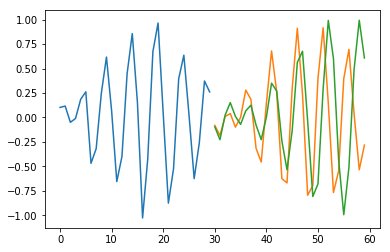

1
0.123786600272 0.481020693342
13.8665183677


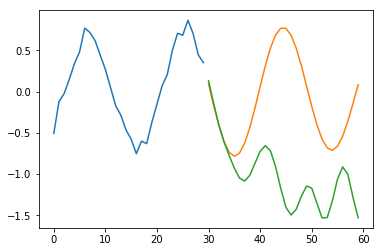

2
-0.360977379142 0.374688853517
15.154638738


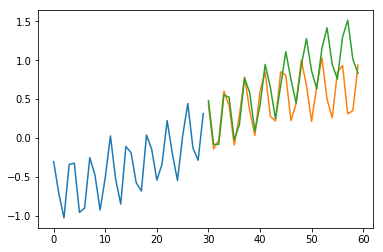

3
0.00851071250576 0.116814539439
1.77984152313


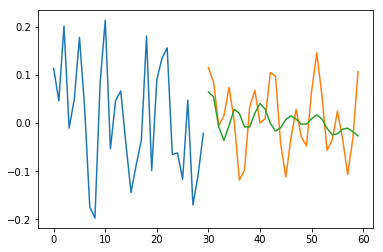

4
0.00742635271112 0.271538582168
9.63134307942


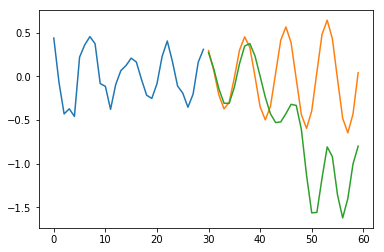

5
-0.0133444550916 0.359008773735
9.68265642821


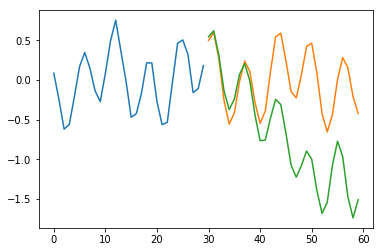

6
-0.0103940860089 0.353333699629
8.50110397337


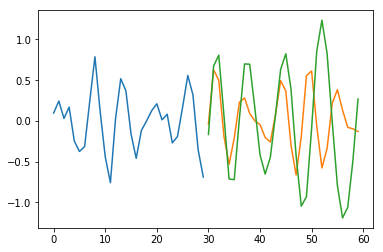

7
-0.00238778362307 0.290874461527
8.23215648274


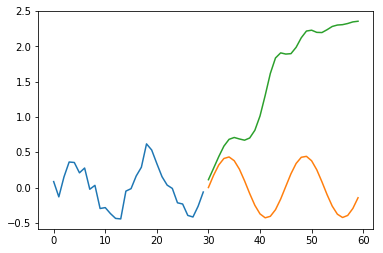

8
-0.037158777642 0.205261329778
4.84124178047


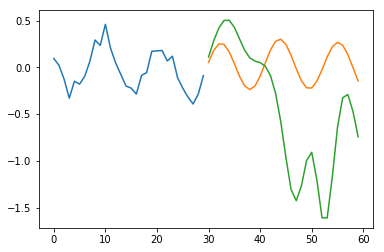

9
-0.109601515334 0.461888585566
11.1546703477


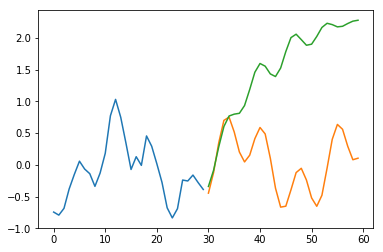

10
0.264934863325 0.428868895144
13.2577324148


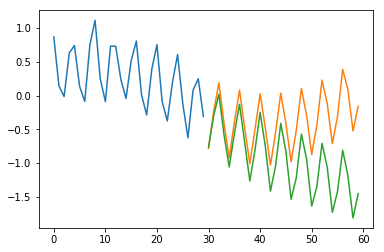

11
-0.0055012090312 0.431303534583
11.0941146409


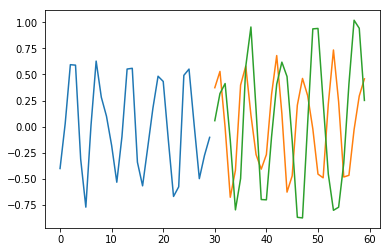

12
0.00442293661276 0.235093622337
5.67296038081


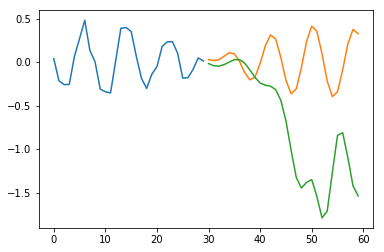

13
0.0373144033472 0.443517288927
12.9777743066


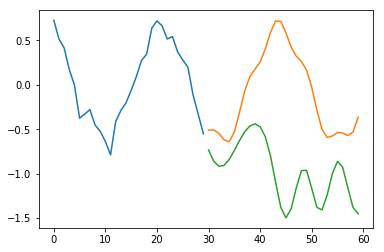

14
-0.334401686493 0.202242497309
8.42491731069


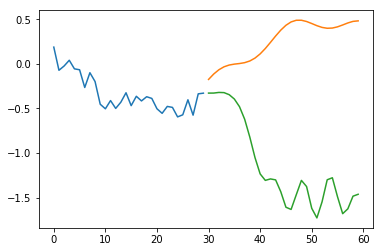

15
-0.145924983423 0.476895655326
14.44763757


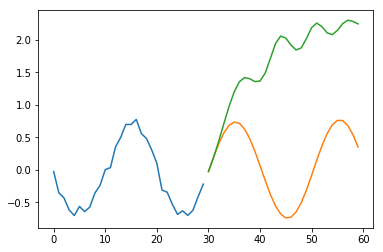

16
-0.0226663353161 0.467099019608
10.8775795924


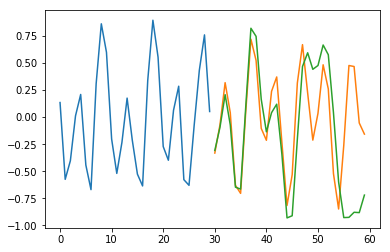

17
-0.0105460726853 0.111086588369
2.17733938193


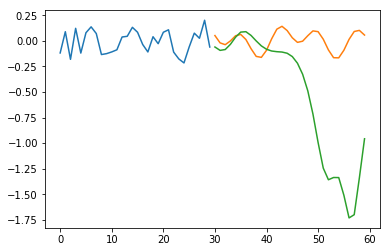

18
-0.0134908768415 0.369172162425
10.5104989313


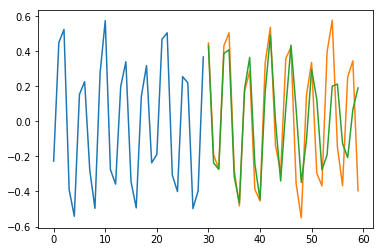

19
0.205065117867 0.347249094218
10.4540359957


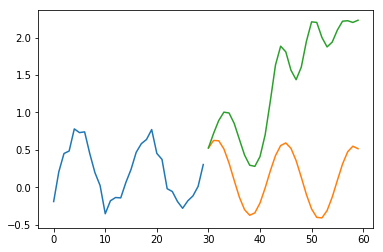

20
-0.0303008270139 0.283698803114
7.53628376865


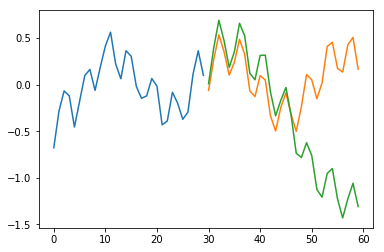

21
0.0437530881481 0.537091647535
12.0741083732


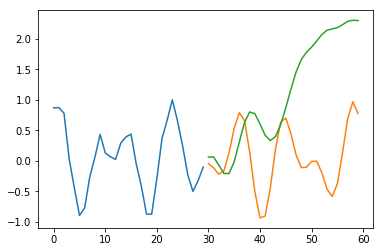

22
0.0195336428681 0.33963351522
8.61514110547


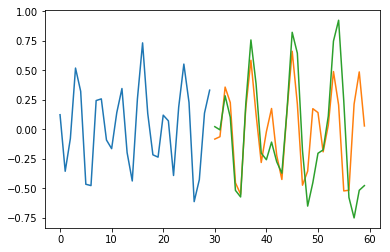

23
-0.0406186774173 0.390401696694
10.693635121


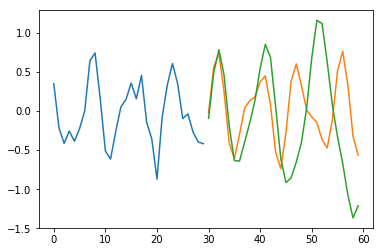

24
0.278946070174 0.255836933123
11.7793733996


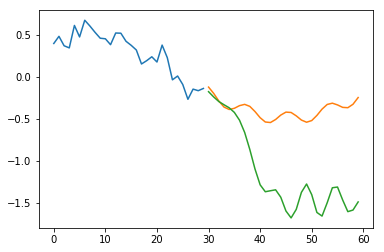

25
-0.0456425729212 0.310506177079
7.47231308699


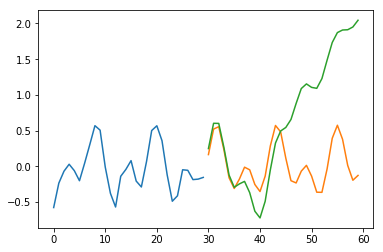

26
0.0107538845588 0.301350046721
9.01315038885


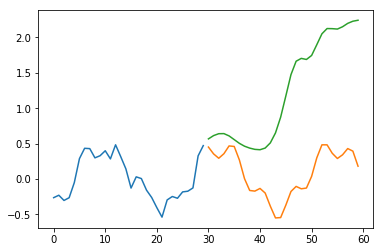

27
0.0323503512726 0.417231267361
11.9476074614


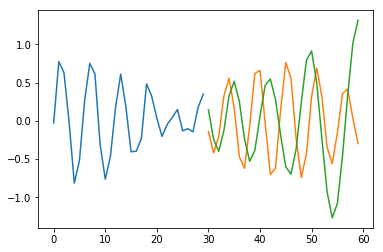

28
-0.0744497193722 0.444574799466
13.4046835623


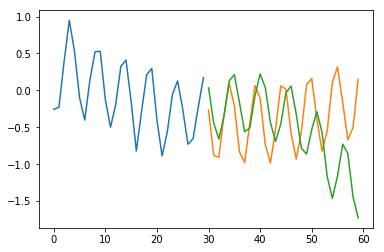

29
0.248122139282 0.315785136197
14.9529865619


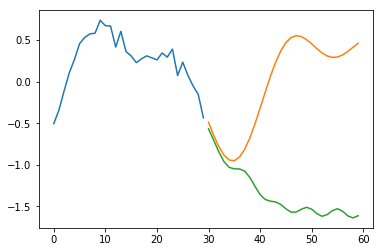

30
0.0167083111597 0.246402762349
14.9822707252


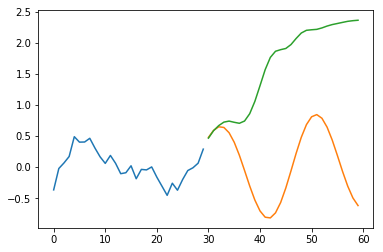

31
0.0453591280262 0.432445326554
10.2021680958


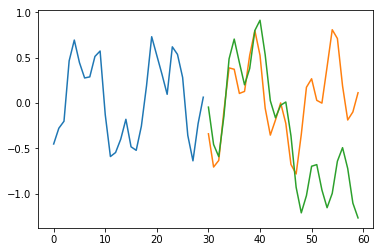

32
-0.0232029617865 0.2485638801
6.56660459496


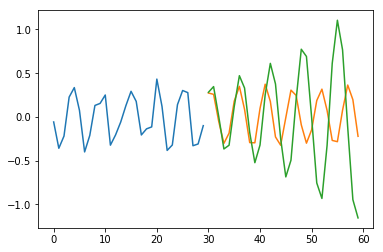

33
0.0107818312762 0.33352418163
7.79287158574


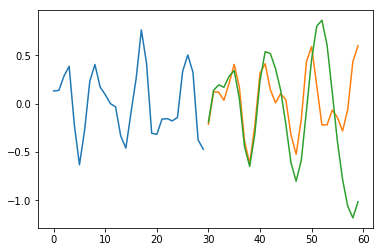

34
-0.0511349683849 0.448479598739
11.9687354354


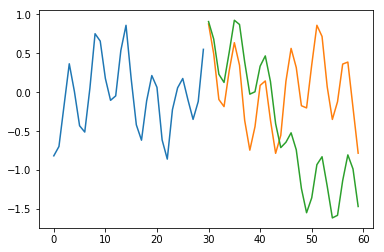

35
0.0550625047504 0.517930276799
13.1993427075


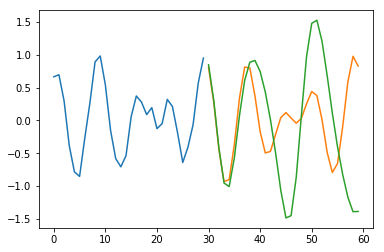

36
0.022190983643 0.577155089721
12.742089138


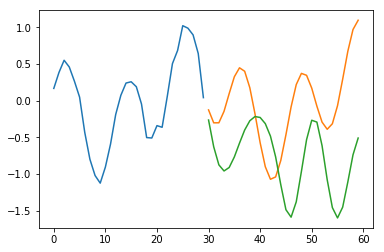

37
0.0401771255707 0.650630113415
9.61404902168


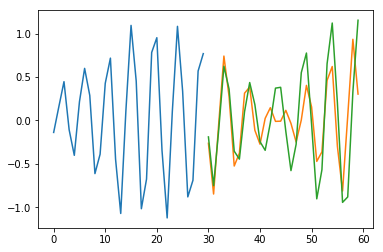

38
0.0175740744446 0.4240687491
9.58063311025


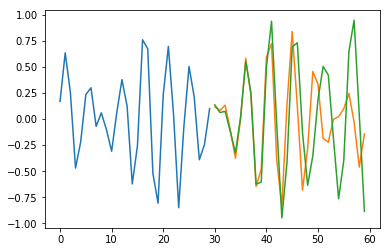

39
0.0188304474808 0.110650065075
0.702621214483


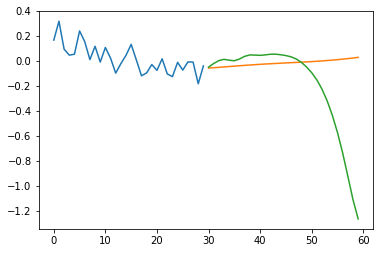

40
-0.0183434909877 0.218814382288
4.88484384323


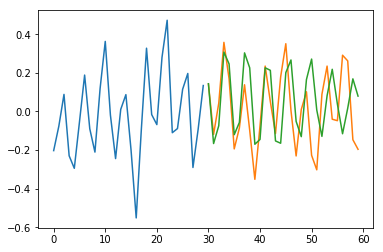

41
-0.00936238231654 0.366641001857
8.43093228734


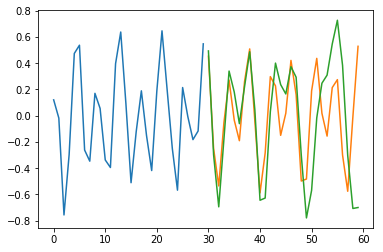

42
0.17407772339 0.396340128734
9.89155731496


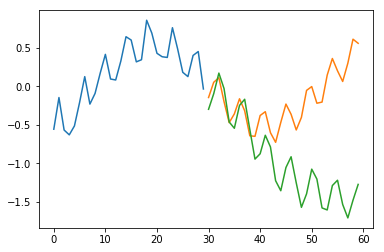

43
0.0147711530818 0.287881409452
6.38301193081


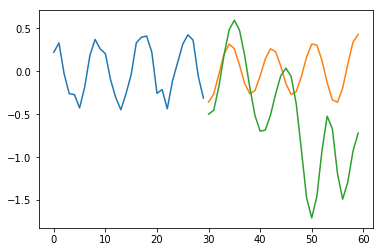

44
0.0370117498754 0.51093841677
14.1480057003


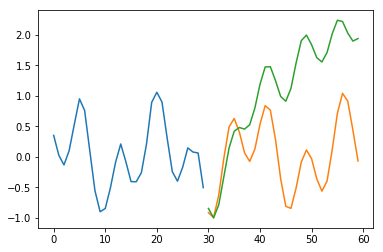

45
0.0223524221652 0.336236620902
8.81377509198


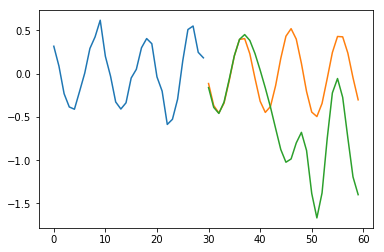

46
0.0331753796796 0.388163542621
8.92478952979


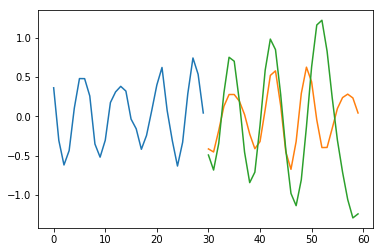

47
-0.547458637419 0.0797331407786
17.2257156465


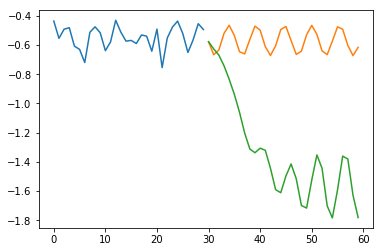

48
0.114808960865 0.299326043586
8.2955839962


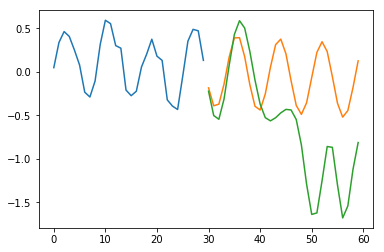

49
-0.0269406912356 0.401762956782
10.6833695348


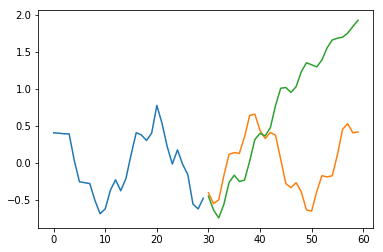

In [19]:
import itertools
n_view = batch_size

# input_batch, target_batch = train_data.next()
input_batch, target_batch = generate_x_y_data_v3(True, batch_size)
input_batch, target_batch = input_batch.reshape(input_batch.shape[0], -1).T, target_batch.reshape(target_batch.shape[0],-1).T
inputs = input_batch[:n_view, :]
targets = target_batch[:n_view,:]
feed_dict = {train: False}
preds = sess.run(reshaped_outputs, feed_dict=feed_vals(inputs, targets, feed_dict, n_cond, n_pred))

for i in range(inputs.shape[0]):
    fig = plt.figure()
    print(i)
    print(np.mean(inputs[i,:]), np.std(inputs[i,:]))
    mean_err_per_timestep = np.abs(0 - targets[i,:])
    total_err = np.sum(mean_err_per_timestep)
    print(total_err)
    plt.plot(inputs[i,:])
    plt.plot([n_cond+j for j in range(n_pred)], targets[i,:])
    plt.plot([n_cond+j for j in range(n_pred)], [p[i][0] for p in preds])
    plt.show()

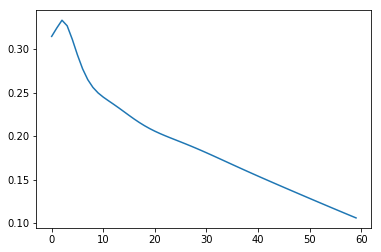

In [115]:
plt.plot([p[7][0] for p in preds])